In [1]:
import os
import random
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, Activation, SimpleRNN
from tensorflow.keras.layers import BatchNormalization, Reshape, MaxPooling2D, GlobalAveragePooling2D, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image
from PIL import UnidentifiedImageError

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import itertools
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import FastICA
from sklearn.ensemble import RandomForestClassifier

In [2]:
#===============importing the dataset from the directory========================#
Healthy = os.listdir("D:\kaggle\input\diabetic-retinopathy-dataset\Healthy")
Mild = os.listdir('D:\kaggle\input\diabetic-retinopathy-dataset\Mild DR')
Moderate = os.listdir('D:\kaggle\input\diabetic-retinopathy-dataset\Moderate DR')
Proliferate = os.listdir('D:\kaggle\input\diabetic-retinopathy-dataset\Proliferate DR')
Severe = os.listdir('D:\kaggle\input\diabetic-retinopathy-dataset\Severe DR')

In [3]:
img_w, img_h = 225, 225 #setting the image width and height for easy processing
X = []
y = []

for i in Healthy:
    try:
        img = Image.open("D:\\kaggle\\input\\diabetic-retinopathy-dataset\\Healthy\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(0)
    except UnidentifiedImageError: # it passes an image that wasn't correctly identified
        pass
    
for i in Mild:
    try:
        img = Image.open("D:\\kaggle\\input\\diabetic-retinopathy-dataset\\Mild DR\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass
    
for i in Moderate:
    try:
        img = Image.open("D:\\kaggle\\input\\diabetic-retinopathy-dataset\\Moderate DR\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(1)
    except UnidentifiedImageError:
        pass
    
for i in Proliferate:
    try:
        img = Image.open("D:\\kaggle\\input\\diabetic-retinopathy-dataset\\Proliferate DR\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass
    
for i in Severe:
    try:
        img = Image.open("D:\\kaggle\\input\\diabetic-retinopathy-dataset\\Severe DR\\" + i).convert('RGB')
        img = img.resize((img_w,img_h))
        X.append(np.asarray(img))
        y.append(2)
    except UnidentifiedImageError:
        pass
    
X = np.asarray(X)
y = np.asarray(y)
print(X.shape, y.shape)

# I resized each image to our manually defined width and height(img_w, img_h)
# I also changed the images to an array



(108, 225, 225, 3) (108,)


In [4]:
x = X.astype('float32')
x /= 255

#scaler = MinMaxScaler()
#x = scaler.fit_transform(x)



num_classes = 3

labels = keras.utils.to_categorical(y, num_classes)
print(labels[0])

[1. 0. 0.]


In [5]:
# splitting our dataset into train and test
x_train1, x_test, y_train1, y_test = train_test_split(x, labels, test_size = 0.3, random_state=5)
x_train,x_val,y_train,y_val=train_test_split(x_train1,y_train1,test_size=0.3,random_state=5)

print('Number of train: {}'.format(len(x_train)))
print('Number of validation: {}'.format(len(x_val)))
print('Number of test: {}'.format(len(x_test)))

Number of train: 52
Number of validation: 23
Number of test: 33


In [6]:
# An image data generator is a tool provided by keras to easily perform data augmentation on images
# Data augmentation simply takes an image for instance and adds different ways the image can be presented
# for example like rotating the image, flipping the image, changing the scale e.t.c
# when training the images, data augmentation is done in real time while the image is undergoing training
# which makes it very remarkable and awesome to use
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=20.,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=30.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=0.2,
    vertical_flip=0.2,
    rescale=None)

datagen.fit(x_train)



In [7]:
base_model = tf.keras.applications.InceptionV3(input_shape=(225,225,3),include_top=False,weights="imagenet")

In [8]:
for layer in base_model.layers[:-10]:
    layer.trainable=False

In [9]:
# My neural network consists of 3 layers densely connected
# dropout helps prevent over fitting of the model when testing it
model_ann=Sequential()
model_ann.add(base_model)
model_ann.add(Dropout(0.2))
model_ann.add(Flatten())
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dense(128, activation='relu'))
model_ann.add(Dense(3, activation='softmax'))
model_ann.summary() # printing out the summary of the model for better understanding for you

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6553728   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 28,373,411
Trainable params: 6,570,819
Non-trainable params: 21,802,592
____________________________________

In [23]:

#plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
#Image(filename='convnet.png')

In [10]:
# here i am defining my performance metrics to check the performance of the model
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 3*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

In [11]:
lrd = ReduceLROnPlateau(monitor = 'recall',patience = 30,verbose = 1,factor = 0.70, min_lr = 1e-5)
# the above line of code reduces the learning rate when there is no improvement to the metric
# i added this line of code because i trained the model without it and the performance was stagnant
# the performance was stuck on 0.96nnn as the accuracy so i added the line of code to reduce
# the learing rate after two epochs
mcp = ModelCheckpoint('model.h5')
es = EarlyStopping(verbose=1, patience=40)

model_ann.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

In [12]:
# this is where i fit and trained my model
%time
history=model_ann.fit(x_train1,y_train1,validation_data=(x_val,y_val),epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

Wall time: 0 ns
Epoch 1/20
3/3 [==============================] - 121s 24s/step - loss: 9.2899 - accuracy: 0.3867 - precision: 0.3860 - recall: 0.2933 - auc: 0.5442 - f1_score: 0.5357 - val_loss: 6.1741 - val_accuracy: 0.4348 - val_precision: 0.4348 - val_recall: 0.4348 - val_auc: 0.6432 - val_f1_score: 0.6522
Epoch 2/20
3/3 [==============================] - 37s 12s/step - loss: 2.4530 - accuracy: 0.6667 - precision: 0.6667 - recall: 0.6667 - auc: 0.8336 - f1_score: 0.9901 - val_loss: 3.6162 - val_accuracy: 0.6087 - val_precision: 0.6087 - val_recall: 0.6087 - val_auc: 0.7391 - val_f1_score: 0.9130
Epoch 3/20
3/3 [==============================] - 36s 12s/step - loss: 2.8490 - accuracy: 0.6667 - precision: 0.6667 - recall: 0.6667 - auc: 0.8060 - f1_score: 1.0199 - val_loss: 1.3092 - val_accuracy: 0.8696 - val_precision: 0.8696 - val_recall: 0.8696 - val_auc: 0.9367 - val_f1_score: 1.3043
Epoch 4/20
3/3 [==============================] - 36s 12s/step - loss: 0.8975 - accuracy: 0.9067 -

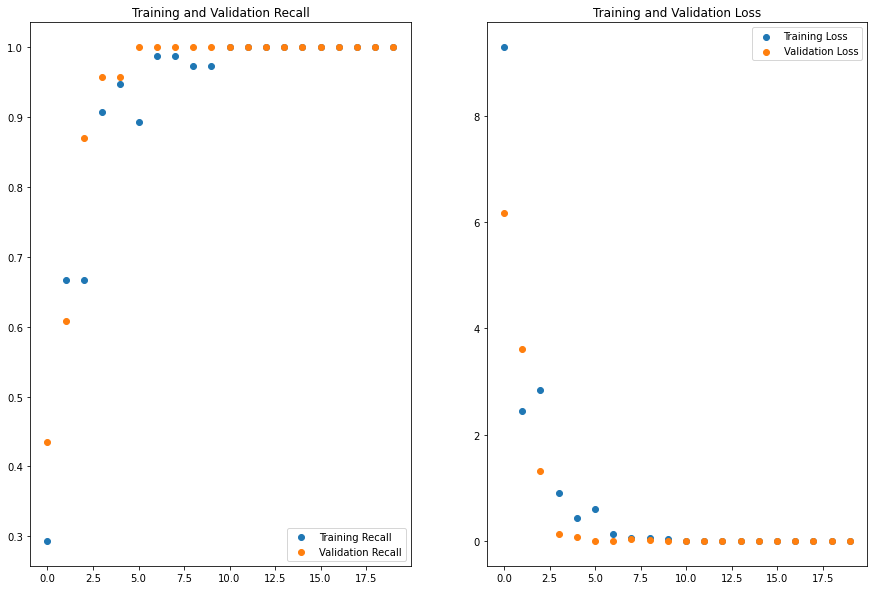

In [13]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [17]:
y_pred = model.predict(x_test)
def plot_roc_curve(ytest, ypred):
    num_classes = len(np.unique(ytest))
    ytest = label_binarize(ytest, classes=np.asarray(num_classes))
    ypred = label_binarize(ypred, classes=np.asarray(num_classes))

  # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(ytest[:, i], ypred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

  # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
    mean_tpr /= num_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  #plt.figure(figsize=(10,5))
    plt.figure(dpi=600)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle=":", linewidth=4,)

    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) curve")
    plt.legend()

NameError: name 'model' is not defined

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Healty       0.92      0.79      0.85        14
     caution       0.78      0.82      0.80        17
      severe       0.33      0.50      0.40         2

    accuracy                           0.79        33
   macro avg       0.68      0.70      0.68        33
weighted avg       0.81      0.79      0.80        33



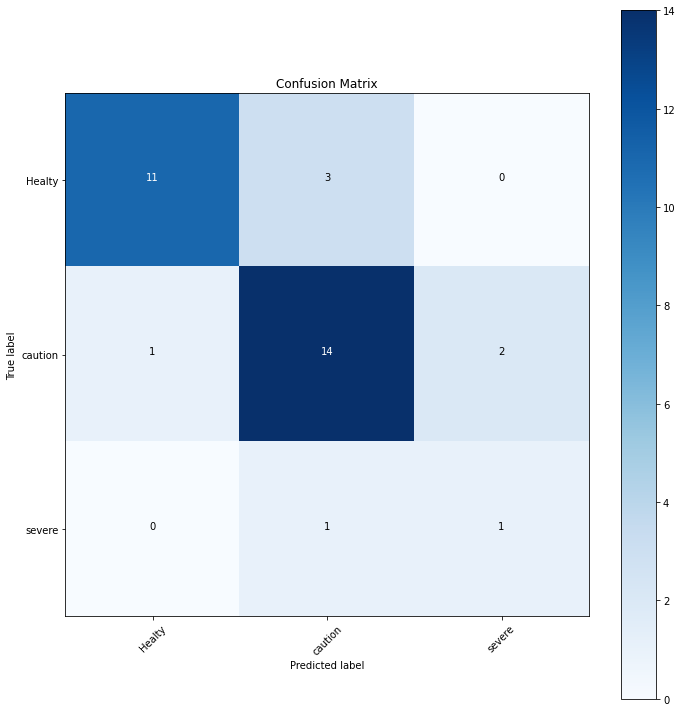

In [14]:
# here i want to define and plot my confusion matrix
# and also my classification report
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
y_pred = (model_ann.predict(x_test) > 0.5).astype("int32")

y_test_c = np.argmax(y_test, axis=1)
target_names = ["Healty", "caution", "severe"]

Y_pred = np.argmax(model_ann.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c, Y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c, Y_pred, target_names=target_names))


#=====================important note==============================#
# this model i created basically classifies different cases into 3 and they are
# healthy(meaning the eye is healthy and free from any retinopathy)
# caution(meaning the eye has some detected disfunctionalities and immediate treatemet has to commence
# before it worsens)
# and severe(meaning that the eye is under serious attack from by retinopathy and in severe condition)
# so its either the eye is healthy severe or needs to be treated with caution

In [15]:
model_cnn = Sequential()
#model_cnn.add = (base_model)
model_cnn.add(Conv2D(filters = 32, kernel_size = 2, activation = 'relu', input_shape=(225, 225, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(filters = 64, kernel_size = 2, activation = 'relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation = 'relu'))
model_cnn.add(Dense(3, activation = 'softmax'))
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 224, 224, 32)      416       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 111, 111, 64)      8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 193600)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               24780928  
_________________________________________________________________
dense_4 (Dense)              (None, 3)                

In [16]:
model_cnn.compile(optimizer='Adam', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)

In [17]:
%time
history1=model_cnn.fit(x_train,y_train,validation_data=(x_val,y_val),epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

Wall time: 0 ns
Epoch 1/20
2/2 [==============================] - 32s 13s/step - loss: 6.4204 - accuracy: 0.6133 - precision: 0.7209 - recall: 0.4133 - auc: 0.7700 - f1_score: 0.3000 - val_loss: 51.7859 - val_accuracy: 0.3913 - val_precision: 0.3913 - val_recall: 0.3913 - val_auc: 0.5435 - val_f1_score: 0.5870
Epoch 2/20
2/2 [==============================] - 8s 4s/step - loss: 40.5718 - accuracy: 0.4423 - precision: 0.4423 - recall: 0.4423 - auc: 0.5817 - f1_score: 0.6656 - val_loss: 20.1442 - val_accuracy: 0.3913 - val_precision: 0.3913 - val_recall: 0.3913 - val_auc: 0.5435 - val_f1_score: 0.5870
Epoch 3/20
2/2 [==============================] - 8s 4s/step - loss: 12.3905 - accuracy: 0.4038 - precision: 0.4038 - recall: 0.4038 - auc: 0.5790 - f1_score: 0.5906 - val_loss: 9.7131 - val_accuracy: 0.3913 - val_precision: 0.3913 - val_recall: 0.3913 - val_auc: 0.5435 - val_f1_score: 0.5870
Epoch 4/20
2/2 [==============================] - 9s 4s/step - loss: 7.6305 - accuracy: 0.4231 - pr

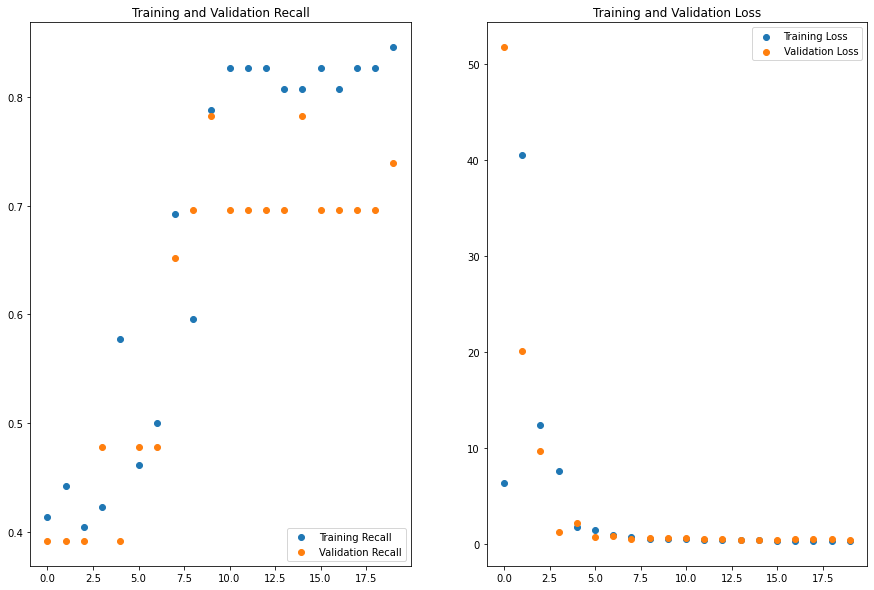

In [18]:
acc1 = history1.history['recall']
val_acc1 = history1.history['val_recall']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs_range1 = range(len(history1.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range1, acc1, label='Training Recall')
plt.scatter(epochs_range1, val_acc1, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range1, loss1, label='Training Loss')
plt.scatter(epochs_range1, val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Healty       0.92      0.79      0.85        14
     caution       0.76      0.94      0.84        17
      severe       0.00      0.00      0.00         2

    accuracy                           0.82        33
   macro avg       0.56      0.58      0.56        33
weighted avg       0.78      0.82      0.79        33



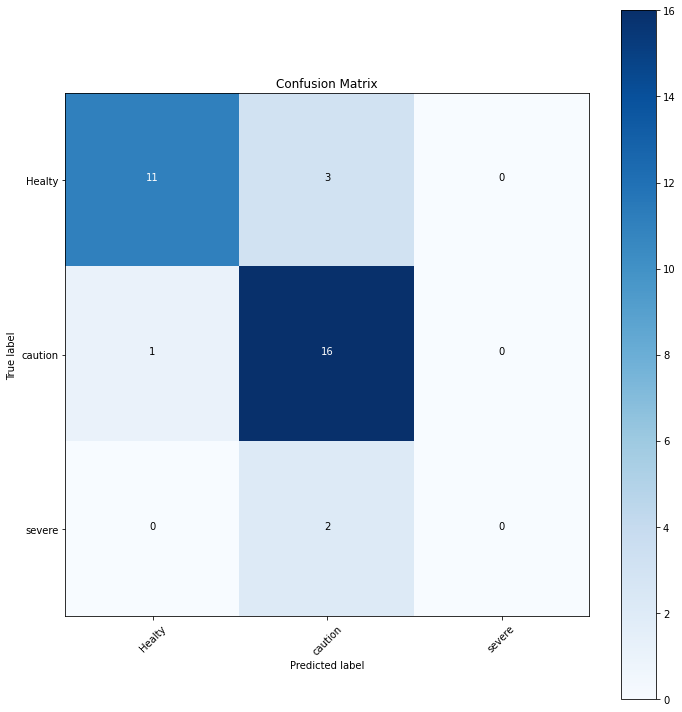

In [19]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
y_pred1 = (model_cnn.predict(x_test) > 0.5).astype("int32")

y_test_c1 = np.argmax(y_test, axis=1)
target_names1 = ["Healty", "caution", "severe"]

Y_pred1 = np.argmax(model_cnn.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c1, Y_pred1)
plot_confusion_matrix(cm, target_names1, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c1, Y_pred1, target_names=target_names1))

In [34]:
#Deep learning model
model_rnn = keras.Sequential()
#model_rnn.add(BatchNormalization(input_shape=(225,225,3)))
model_rnn.add(SimpleRNN(20, input_shape=(225, 3)))
model_rnn.add(Dense(128, activation='relu'))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(128, activation='relu'))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.3))
model_rnn.add(Dense(3, activation='softmax'))
model_rnn.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 20)                480       
_________________________________________________________________
dense_8 (Dense)              (None, 128)               2688      
_________________________________________________________________
batch_normalization_105 (Bat (None, 128)               512       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_106 (Bat (None, 128)               512       
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)             

In [12]:
TLA2 = tf.keras.applications.resnet50.ResNet50(input_shape=(225,225,3),include_top=False,weights="imagenet")

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 4d473c1dd8becc155b73f8504c6f6626 so we will re-download the data.
94773248/94765736 [==============================] - 246s 3us/step


In [13]:
for layer in TLA2.layers[:-10]:
    layer.trainable=False

In [14]:
model_resnet=Sequential()
model_resnet.add(TLA2)
model_resnet.add(Dropout(0.2))
model_resnet.add(Flatten())
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dense(3, activation='softmax'))
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16777344  
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 387       
Total params: 40,381,955
Trainable params: 21,259,907
Non-trainable params: 19,122,048
_________________________________

In [16]:
model_resnet.compile(optimizer='rmsprop', loss = tf.keras.losses.CategoricalCrossentropy(),metrics=METRICS)
%time
history=model_resnet.fit(x_train,y_train,validation_data=(x_val,y_val),epochs = 20,verbose = 1,callbacks=[lrd,mcp,es])

Wall time: 0 ns
Epoch 1/20
2/2 [==============================] - 140s 51s/step - loss: 16.0147 - accuracy: 0.5000 - precision: 0.5152 - recall: 0.3269 - auc: 0.6212 - f1_score: 0.6125 - val_loss: 321.6167 - val_accuracy: 0.3913 - val_precision: 0.3913 - val_recall: 0.3913 - val_auc: 0.5435 - val_f1_score: 0.5870
Epoch 2/20
2/2 [==============================] - 67s 37s/step - loss: 59.1353 - accuracy: 0.4231 - precision: 0.4231 - recall: 0.4231 - auc: 0.5673 - f1_score: 0.6281 - val_loss: 208.8172 - val_accuracy: 0.3913 - val_precision: 0.3913 - val_recall: 0.3913 - val_auc: 0.5435 - val_f1_score: 0.5870
Epoch 3/20
2/2 [==============================] - 70s 38s/step - loss: 19.2792 - accuracy: 0.4231 - precision: 0.4231 - recall: 0.4231 - auc: 0.5673 - f1_score: 0.6141 - val_loss: 15.1937 - val_accuracy: 0.3913 - val_precision: 0.3913 - val_recall: 0.3913 - val_auc: 0.5435 - val_f1_score: 0.5870
Epoch 4/20
2/2 [==============================] - 67s 37s/step - loss: 5.4115 - accuracy: 

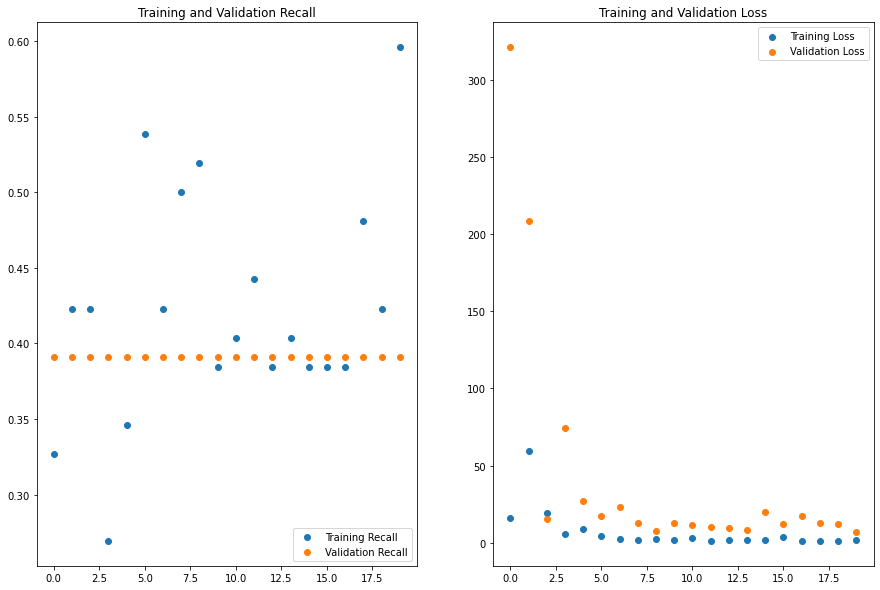

In [17]:
acc = history.history['recall']
val_acc = history.history['val_recall']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(history.history['val_loss']))
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.scatter(epochs_range, acc, label='Training Recall')
plt.scatter(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')
plt.subplot(1, 2, 2)
plt.scatter(epochs_range, loss, label='Training Loss')
plt.scatter(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Healty       0.42      1.00      0.60        14
     caution       0.00      0.00      0.00        17
      severe       0.00      0.00      0.00         2

    accuracy                           0.42        33
   macro avg       0.14      0.33      0.20        33
weighted avg       0.18      0.42      0.25        33



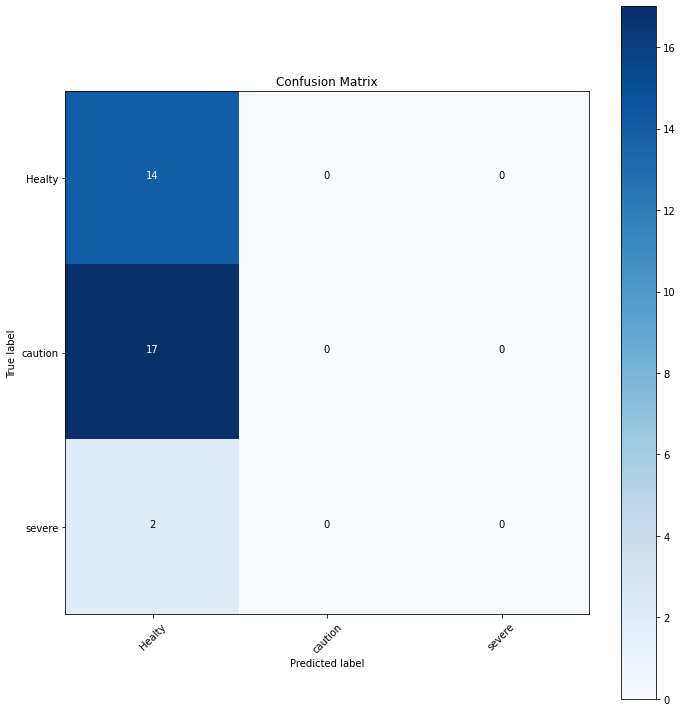

In [18]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
y_pred2 = (model_resnet.predict(x_test) > 0.5).astype("int32")

y_test_c2 = np.argmax(y_test, axis=1)
target_names = ["Healty", "caution", "severe"]

Y_pred2 = np.argmax(model_resnet.predict(x_test),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_c2, Y_pred2)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(y_test_c2, Y_pred2, target_names=target_names))
